This work utilizes a dataset created by the Energy Data Analytics Lab at Duke University. The dataset contains geospatial data and border vertices for over 19,000 solar panels, located in the California cities of Fresno, Stockton, Oxnard, and Modesto. The full dataset of images and annotations can be found [here](https://figshare.com/collections/Full_Collection_Distributed_Solar_Photovoltaic_Array_Location_and_Extent_Data_Set_for_Remote_Sensing_Object_Identification/3255643/3).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from skimage import io
import matplotlib.cm as cm
from matplotlib.patches import Circle, Polygon

#Importing raw data from the CSV files.
pv_arrays = pd.read_csv("version1\polygonDataExceptVertices.csv")
vertices = pd.read_csv("version1\polygonVertices_PixelCoordinates.csv")

print(pv_arrays.shape)
print(vertices.shape)


(19863, 17)
(19863, 294)


Description of the columns:

polygon_id -> Each PV array corresponds to a polygon

centroid_latitude/centroid_longitude -> latitude and longitude of the centroid of the polygon

centroid_latitude_pixels/centroid_longitude_pixels -> pixel co-ordinates of the centroid of the polygon

city -> location of the PV array

area_pixels -> Area given by Google Earth when you draw a polygon around the PV array

area_meters -> ?

image_name -> image containing the PV array

nw_corner_of_image_latitude/nw_corner_of_image_longitude/se_corner_of_image_latitude/se_corner_of_image_longitude -> latitudes 
and longitudes of the corners of the image.

datum -> ? (not used)

projection_zone -> ? (not used)

resolution -> meters per pixel

jaccard_index -> ? (not used)

NOTE: Somehow area_meters and area_pixels are related, as area_meters divided by area_pixels ~ 11.1 for all polygons 

In [2]:
pv_arrays.head()

,polygon_id,centroid_latitude,centroid_longitude,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,nw_corner_of_image_latitude,nw_corner_of_image_longitude,se_corner_of_image_latitude,se_corner_of_image_longitude,datum,projection_zone,resolution,jaccard_index
0,1,36.926055,-119.840241,107.618458,3286.151487,Fresno,136.192872,1513.254134,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.914020
1,2,36.926217,-119.840241,45.977659,3286.352946,Fresno,155.511714,1727.907934,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.829071
2,3,36.926277,-119.840174,22.280851,3303.465657,Fresno,111.796591,1242.184349,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.937961
3,4,36.920969,-119.842798,2048.362567,2547.366116,Fresno,62.004008,688.933420,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.842634
4,5,36.920938,-119.842859,2060.014890,2529.504997,Fresno,95.480150,1060.890554,11ska460890,36.926336,-119.851622,36.913233,-119.8343,NAD83,11,0.3,0.890998


In [3]:
vertices.head()

,dataPolygonsPixels1,dataPolygonsPixels2,dataPolygonsPixels3_ 1,dataPolygonsPixels3_ 2,dataPolygonsPixels3_ 3,dataPolygonsPixels3_ 4,dataPolygonsPixels3_ 5,dataPolygonsPixels3_ 6,dataPolygonsPixels3_ 7,dataPolygonsPixels3_ 8,...,dataPolygonsPixels3_283,dataPolygonsPixels3_284,dataPolygonsPixels3_285,dataPolygonsPixels3_286,dataPolygonsPixels3_287,dataPolygonsPixels3_288,dataPolygonsPixels3_289,dataPolygonsPixels3_290,dataPolygonsPixels3_291,dataPolygonsPixels3_292
0,1,8,131.631164,3360.495069,87.985141,3249.197710,73.850000,3213.750000,81.950000,3210.450000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,9,69.615385,3361.153846,12.846154,3217.615385,13.096107,3217.440417,12.450000,3215.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11,48.136863,3358.015726,48.150000,3358.050000,42.379290,3360.742998,39.467456,3362.122288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,9,2068.049310,2571.591716,2067.393899,2571.021266,2067.150000,2571.350000,2021.550000,2531.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9,2091.398422,2563.781065,2021.674556,2504.416174,2022.048728,2503.979640,2021.550000,2503.550000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As you can see above, the 'polygonVertices_PixelCoordinates.csv' file contains the vertice co-ordinates of each of the vertices for a given polygon. This however has to be cleaned to get the co-ordinates of the vertices in (x,y) format.

In [4]:
flat = pd.melt(vertices, id_vars=['dataPolygonsPixels1','dataPolygonsPixels2'])#Melting the data to have just the first two columns
flat = flat.dropna() #drop rows with empty values
flat['value'] = flat['value'].map(lambda x: int(round(x))) #Rounding the pixel values of the vertices
flat['pixel_id'] = flat['variable'].map(lambda x: int(x.replace(' ','').split('_')[1])) #Extract the pixel id from the column name
flat.drop('variable', axis=1, inplace=True)  
pair1 = zip(range(1,292,2), range(2,293,2)) # Creating iterators (1,2),(3,4),(5,6) ....(291,292) for each each vertex pixel co-ordinates
pair2 = zip(range(1,292,2), range(2,293,2)) 
pairs = [pair for double in zip(pair1, pair2) for pair in double]# Since we have 292 pixel id's corresponding to 146 vertices - each pixel id must have the right pair. So we need 292 pairs... (1,2)(1,2)(3,4)(3,4)...(291,292)(291,292)    
flat['pair'] = flat['pixel_id'].map(lambda x: pairs[x - 1])# Assign the correct pairs for each pixel
even = flat[(flat['pixel_id'] % 2 == 0)] #Even pixel ids
odd = flat[~(flat['pixel_id'] % 2 == 0)] #Odd pixel ids
flat_merge = odd.merge(even, on=['dataPolygonsPixels1','dataPolygonsPixels2','pair'])#Merging the values on polygonId and Vertices
flat_merge['coordinate'] = list(map(lambda x, y: (x, y), flat_merge['value_x'].values, flat_merge['value_y'].values))#creating a coordinate column  
polygon_vertices = flat_merge[['dataPolygonsPixels1','coordinate']] #recombining all coordinate pairs by polygon id
polygon_vertices = pd.pivot_table(polygon_vertices, index='dataPolygonsPixels1', values='coordinate',
                                 aggfunc=lambda x: x.values.tolist())#Creating a dataframe with polygon id as index and combining all the acoordinates of its vertices 
polygon_vertices = polygon_vertices.reset_index() #restore to previous index
polygon_vertices.columns = ['polygon_id','polygon_vertices'] #Renaming the columns


Now we need to merge this into the pv_arrays dataframe.

In [5]:
pv_arrays_clean = pv_arrays.merge(polygon_vertices, how='inner', on='polygon_id')
pv_arrays_clean = pv_arrays_clean[['polygon_id', 'centroid_latitude_pixels', 'centroid_longitude_pixels', 'city','area_pixels','area_meters', 
                            'image_name', 'polygon_vertices']]
pv_arrays_clean.head()

,polygon_id,centroid_latitude_pixels,centroid_longitude_pixels,city,area_pixels,area_meters,image_name,polygon_vertices
0,1,107.618458,3286.151487,Fresno,136.192872,1513.254134,11ska460890,"[(132, 3360), (88, 3249), (74, 3214), (82, 321..."
1,2,45.977659,3286.352946,Fresno,155.511714,1727.907934,11ska460890,"[(70, 3361), (13, 3218), (13, 3217), (12, 3216..."
2,3,22.280851,3303.465657,Fresno,111.796591,1242.184349,11ska460890,"[(48, 3358), (48, 3358), (42, 3361), (39, 3362..."
3,4,2048.362567,2547.366116,Fresno,62.004008,688.933420,11ska460890,"[(2068, 2572), (2067, 2571), (2067, 2571), (20..."
4,5,2060.014890,2529.504997,Fresno,95.480150,1060.890554,11ska460890,"[(2091, 2564), (2022, 2504), (2022, 2504), (20..."


In [6]:
pv_arrays_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19863 entries, 0 to 19862
Data columns (total 8 columns):
polygon_id                   19863 non-null int64
centroid_latitude_pixels     19861 non-null float64
centroid_longitude_pixels    19861 non-null float64
city                         19863 non-null object
area_pixels                  19863 non-null float64
area_meters                  19863 non-null float64
image_name                   19863 non-null object
polygon_vertices             19863 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 1.4+ MB


Exploratory Data Analysis.

Number of array annotations and satellite images for each city.


In [7]:
poly_agg = pv_arrays_clean.groupby(['city','image_name'])[['polygon_id']].count().reset_index() #Number of polygons per image 
pv_array_agg = poly_agg.groupby('city')[['image_name']].count().reset_index() #Number of images per city 
pv_array_agg = pv_array_agg.merge(poly_agg.groupby('city')[['polygon_id']].sum().reset_index())#Number of polygons per city
pv_array_agg

,city,image_name,polygon_id
0,Fresno,312,14803
1,Modesto,19,613
2,Oxnard,52,1765
3,Stockton,85,2682


Since Fresno data is very big, we use the images from other other 3 cities (Modesto, Oxnard, Stockton) for the initial analysis.

In [8]:
 
# Different cities
cities = pv_array_agg['city'].unique()


In [9]:
# Reading in the number of available images in the dataset
avail_files = []

for city in cities: 
    path ='C:/Users/kaush/Documents/Dataset/%s'%(city)
    try:
        avail_files.extend(listdir(path))
    except:
        continue
#Stores all the image files in the
avail_files = [name[:-4] for name in avail_files if name[-4:] == '.tif']

In [10]:
avail_arrays = pv_arrays_clean[pv_arrays_clean['image_name'].isin(avail_files)]#Make an array of actually available images
#plotting the number of images and polygon ids available in each array
avail_poly_agg = avail_arrays.groupby(['city','image_name'])[['polygon_id']].count().reset_index()
avail_array_agg = avail_poly_agg.groupby('city')[['image_name']].count().reset_index()
avail_array_agg = avail_array_agg.merge(avail_poly_agg.groupby('city')[['polygon_id']].sum().reset_index())
#avail_array_agg = avail_array_agg.sort_values(by='image_name', ascending=False)
avail_array_agg

,city,image_name,polygon_id
0,Fresno,34,2083
1,Modesto,19,613
2,Oxnard,52,1765
3,Stockton,85,2682


Images are 5000*5000 pixels-  RGB. 

Now let's plot the centroid of the arrays in any given image.

In [11]:
# # Plot centers of all solar arrays for a given satellite image

# def plot_centroids(img_id):
    
#     # Use img_id to get the city name from the CSV file 
#     city = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['city'].values[0]
    
#     # Read in image
#     img = io.imread('C:/Users/kaush/Documents/Dataset/%s/%s.tif' % (city, img_id))
    
#     # Extract centroid coordinates from dataframe   
#     arrays_sub = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id] #Create a dataframe containing only entries (polygon ids) corresponding to this img_id
    
#     #Obtain the coordinates for the centroid.
#     coordinates = zip(list(arrays_sub['centroid_longitude_pixels']),
#                       list(arrays_sub['centroid_latitude_pixels']))

#     # Display image
#     fig,ax = plt.subplots(figsize=(12, 12))

#     ax.imshow(img[:,:,1], cmap=cm.gray)
    
#     # Plot a circle for each solar panel array
#     for x, y in coordinates:
#         centroid = Circle((x, y), 20, color='blue')
#         ax.add_patch(centroid)

In [12]:
# plot_centroids('10sfg810685')

In [112]:
# Plot polygon outline for a given solar panel array

def plot_polygon(poly_id):
      
    img_id = pv_arrays_clean[pv_arrays_clean['polygon_id'] == poly_id]['image_name'].values[0] #Get the image_name from the polygon id 
    city = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['city'].values[0] #From the image name, find the city
        
    # Extract polygon vertices from dataframe, calculate min/max
    vertices = pv_arrays_clean[pv_arrays_clean['polygon_id'] == poly_id][['polygon_vertices']].iloc[0,0] #Extract the corresponding vertices of the polygon
    x_values = [x[0] for x in vertices] #x values of all the vertices 
    y_values = [y[1] for y in vertices] #y values of all the vertices
    
    #Minimum and maximum of the x and y axes to crop the image
    x_min, x_max = min(x_values), max(x_values)  
    y_min, y_max = min(y_values), max(y_values)

    # Read in image, crop   
    img = io.imread('C:/Users/kaush/Documents/Dataset/%s/%s.tif' % (city, img_id))
    extra = 20
    img_cropped = img[x_min - extra : x_max + extra, 
                      y_min - extra : y_max + extra]

    # Display cropped image
    fig,ax = plt.subplots() 

    ax.imshow(img_cropped)

    # Plot a polygon for each solar panel array. Vertices must be flipped to conform to 'Polygon' convention
    resized_coords = [(y - (y_min - extra) - 1, x - (x_min - extra) - 1) for x, y in vertices]
    poly = Polygon(resized_coords, fill=False, color='blue')
    ax.add_patch(poly)

In [14]:
# poly_list = pv_arrays_clean[pv_arrays_clean['image_name'] == '10sfg810685']['polygon_id'].values

# for poly in poly_list[:3]:
#     plot_polygon(poly)

Image Segmentation:

In [15]:
from scipy.stats import describe

from skimage.segmentation import quickshift, mark_boundaries 
from skimage.draw import polygon, polygon_perimeter
from skimage import measure
from skimage import io
from ipywidgets import interact, fixed


In [16]:
# # Load in sample satellite image 
# sample_img = io.imread('C:/Users/kaush/Documents/solar3.jpg')

# # Use ipywidgets to experiment with algorithm parameters

# def plot_segments(img, kernel_size=2, max_dist=10, ratio=0.5):
    
#     fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
#     fig.tight_layout()
    
#     axes[0].imshow(img)
#     axes[0].set_title("Original")
    
#     #mark_boundaries returns image with boundaries between labeled regions highlighted.
#     #quickshift segments image using quickshift clustering in Color-(x,y) space.
#     axes[1].imshow(mark_boundaries(img, quickshift(img, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)))
#     axes[1].set_title("Quickshift Segmentations")

#     plt.show()
    
# interact(plot_segments, img=fixed(sample_img), kernel_size=(1,10,1), max_dist=(0,20,1), ratio=(0,1,0.1))

Feature Extraction

In [29]:
# Extract spatial features

def segment_features_shape(segments, img_id='na', quickshift=False):
    # Skimage segmentation algorithms assign a "0" label, however, measure.regionprops only reads labels > 0 
    # If quickshift == True, add 1 to all segment labels
    if quickshift:
        segments = segments + 1
        
    #print("segments data type", segments.dtype)
    segments = segments.astype(int)# Convert labels to int #shape is 5000,5000
    #print("segments shape",segments.shape)
    segment_labels = np.unique(segments[segments > 0]) #Find the unique elements in segments that would correspond to the PV arrays. Rest of it would be nan
    #print("segments labels shape",segment_labels.shape)
    # For each region/segment, create regionprops object and extract features
    region_props_all = measure.regionprops(segments) # Measure properties of labeled image regions. 
    #print(region_props_all)
    region_features = {}
        
    for i, region in enumerate(region_props_all):    

        shape_features = {}

        shape_features['image_id'] = img_id
        shape_features['segment_id'] = segment_labels[i]
        shape_features['perimeter'] = region.perimeter #Calculate the perimeter
        shape_features['area'] = region.area   #Calculate the area
        shape_features['circleness'] = (4 * np.pi * region.area) / (max(region.perimeter, 1) ** 2) #Calculate the circleness
        shape_features['centroid'] = region.centroid #Calculate the centroid
        shape_features['coords'] = region.coords #Co-ordinates

        region_features[segment_labels[i]] = shape_features #
    
    index = ['image_id', 'segment_id', 'perimeter', 'area', 'circleness', 'centroid', 'coords']
    
    shape_df = pd.DataFrame(region_features, index=index).T 
    
    return shape_df

In [63]:
# Extract color features

def segment_features_color(img, segments, img_id='na', quickshift=False):
    
    # Skimage segmentation algorithms assign a "0" label, however, measure.regionprops only reads labels > 0 
    # If quickshift == True, add 1 to all segment labels
    if quickshift:
        segments = segments + 1
        
    # Convert labels to int and generate unique labels list
    segments = segments.astype(int)
    segment_labels = np.unique(segments[segments > 0])

    # For each segment and channel, calculate summary stats    
    channels = ['r','g','b']    
    region_features = {}
    
    for label in segment_labels:
        region = img[segments == label]  #for each segment
        
        color_features = {}        
               
        for i, channel in enumerate(channels):
            values = describe(region[:,i]) #Compute several descriptive statistics of the passed array.
            
            color_features['image_id'] = img_id
            color_features['segment_id'] = label
            color_features[channel + '_min'] = values.minmax[0]
            color_features[channel + '_max'] = values.minmax[1]
            color_features[channel + '_mean'] = values.mean
            color_features[channel + '_variance'] = values.variance
            color_features[channel + '_skewness'] = values.skewness
            '''Skewness is a measure of symmetry, or more precisely, the lack of symmetry. 
            A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.'''
            color_features[channel + '_kurtosis'] = values.kurtosis
            '''Skewness is a measure of symmetry, or more precisely, the lack of symmetry. 
            A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.'''
            
        region_features[label] = color_features
        
    index = ['image_id','segment_id','r_min','r_max','r_mean','r_variance','r_skewness',
         'r_kurtosis','g_min','g_max','g_mean','g_variance','g_skewness','g_kurtosis',
         'b_min','b_max','b_mean','b_variance','b_skewness','b_kurtosis']
        
    color_df = pd.DataFrame(region_features, index=index).T
        
    return color_df

In [64]:
# Create a mask for all solar panels in the image, with each labeled by its polygon_id

def panel_mask(img_id, use_labels=False):
  
    # Identify city in order to navigate to correct directory 
    city = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['city'].values[0]
    
    # Read in image
    img = io.imread('C:/Users/kaush/Documents/Dataset/%s/%s.tif' % (city, img_id))
    
    # Select polygon vertices for all polygons in image
    vertices = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['polygon_vertices'].values
    
    #polygon ids for each array in the image
    labels = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['polygon_id'].values
    
    # Create scaffolding for mask
    mask = np.zeros((img.shape[0],img.shape[1]))
    mask[mask == 0] = np.nan
    
        
    # Option to use custom labels for each panel array
    if use_labels == False:
        poly_data = enumerate(vertices, 1)
    else:
        poly_data = zip(labels, vertices)
    # Iterate through vertices and assign labels to pixels
    for i, poly in poly_data:
        x = np.array([vert[0] for vert in poly])
        y = np.array([vert[1] for vert in poly])
        mask[polygon(x, y, shape=(img.shape[0],img.shape[1]))] = i #Generate coordinates of pixels within polygon.
        mask[polygon_perimeter(x, y,shape=(img.shape[0],img.shape[1]))] = i #Generate polygon perimeter coordinates.
    #Assigns a label to each of the pixels inside the polygons and along the polygon perimeter.
    return mask

In [65]:
# Create a series of random windows that do not overlap with any solar panels

def no_panel_mask(panel_mask, window_size=100, windows=20):
    
    #the mask with panels is passed in as arguments
    
    panels = panel_mask.copy() 
    mask = np.zeros(panels.shape)
    mask[mask == 0] = np.nan # pixels that are nan are contendors for 
        
    rows = panels.shape[0] #5000
    cols = panels.shape[1] #5000
        
    # Create i number of random windows with no panels
    for i in range(windows): 
    
        search = True
        
        # Iterate until random window found
        while search:

            random_x = np.random.randint(0, rows - window_size + 1) #Return random integer from low (inclusive) to high (exclusive).
            random_y = np.random.randint(0, cols - window_size + 1) # between 0 and 5000-window size
            random_window = panels[random_x: random_x + window_size, random_y: random_y + window_size] #create a random window of specified size
            # End search when random window is all nan, i.e. does not overlap with any panels
            if np.isnan(random_window).sum() == random_window.size:
                # Update mask to include new random window
                mask[random_x: random_x + window_size, random_y: random_y + window_size] = i + 1 
                
                # Update panel_mask copy to avoid duplicate random window on next iteration
                panels[random_x: random_x + window_size, random_y: random_y + window_size] = 0 #panels will have polygon ids as labels. Windows will have zeroes
                
                # Go to next window 
                search = False
                
    return mask

In [66]:
# Return masks

def return_masks(img_id):
    
    # Create panel mask 
    panels = panel_mask(img_id, use_labels=True)
    
    # Create no panel mask 
    no_panels = no_panel_mask(panels, window_size=60, windows=350)
    
    return panels, no_panels

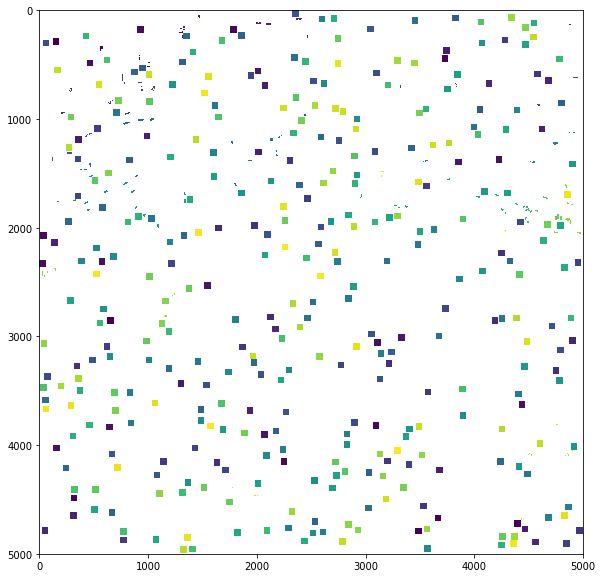

In [67]:
# Create masks for an example image and plot

fig, ax = plt.subplots(figsize=(10,10))

masks = return_masks('10sfg810685')

ax.imshow(masks[0]) #panels
ax.imshow(masks[1]) #No panels
    
plt.show()

In [35]:
# Return features for all solar panels

def extract_pos_features(img_id, quickshift=False):
    
    # Identify city in order to navigate to correct directory 
    city = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['city'].values[0]
        
    # Read in image
    img = io.imread('C:/Users/kaush/Documents/Dataset/%s/%s.tif' % (city, img_id))
    
    # Create panel mask 
    segments_panels = panel_mask(img_id, use_labels=True)
    
    # Extract shape features
    shape_df = segment_features_shape(segments_panels, img_id, quickshift=quickshift)
        
    # Extract color features
    color_df = segment_features_color(img, segments_panels, img_id, quickshift=quickshift)

    # Combine features into single dataframe
    features_df = shape_df.merge(color_df, how='inner', on=['image_id','segment_id'])
    
    return features_df


In [51]:
# Return features for regions without solar panels

def extract_neg_features(img_id, window_size=100, windows=20):
    
    # Identify city in order to navigate to correct directory 
    city = pv_arrays_clean[pv_arrays_clean['image_name'] == img_id]['city'].values[0]
    
    # Read in image
    img = io.imread('C:/Users/kaush/Documents/Dataset/%s/%s.tif' % (city, img_id))
                       
    # Create panel mask 
    segments_panels = panel_mask(img_id, use_labels=True)

    # Create no panel mask 
    windows_no_panels = no_panel_mask(segments_panels, window_size=window_size, windows=windows)
    windows_labels = np.unique(windows_no_panels[windows_no_panels > 0])

    frames = []
    
    for label in windows_labels:

        # Extract window from image
        window_img = img[windows_no_panels == label].reshape((window_size, window_size, 3))
        
        # Divide window into segments using Quickshift segmentation algorithm 
        segments_quick = quickshift(window_img, kernel_size=3, max_dist=8, ratio=0.65)
        segments_labels = np.unique(segments_quick)
        
        # Extract shape features
        shape_df = segment_features_shape(segments_quick, img_id, quickshift=True) 

        # Extract color features
        color_df = segment_features_color(window_img, segments_quick, img_id, quickshift=True)

        # Combine features into single dataframe
        features_df = shape_df.merge(color_df, how='inner', on=['image_id','segment_id'])
        
        # Append to list to facilitate aggregation
        frames.append(features_df)
        
    return pd.concat(frames)

In [52]:
# Input image(s) and feed through entire pipeline, return df of results

def process_images(images):
    
    frames = []
    for img_id in images:
        
        #Extract features of the solar panels 
        pos_features = extract_pos_features(img_id)
        pos_features['panel_class'] = 1
        
        #Extract features of the random windows around these solar panels 
        neg_features = extract_neg_features(img_id, window_size=60, windows=25)
        neg_features['panel_class'] = 0

        combined_features = pd.concat([pos_features, neg_features]) #Combine the features into one dataframe.
        combined_features.dropna(inplace=True)
        
        frames.append(combined_features)
    
    return pd.concat(frames).reset_index(drop=True)

In [53]:
import os

In [54]:
Modesto = os.listdir("C:/Users/kaush/Documents/Dataset/Modesto")
Stockton = os.listdir("C:/Users/kaush/Documents/Dataset/Stockton")
Oxnard = os.listdir("C:/Users/kaush/Documents/Dataset/Oxnard")
image_Names = []
for file in Modesto:
    if file.endswith(".tif"):
        image_Names.append(file[:-4])
for file in Stockton:
    if file.endswith(".tif"):
        image_Names.append(file[:-4])
for file in Oxnard:
    if file.endswith(".tif"):
        image_Names.append(file[:-4])
image_ids = []
new = list(pv_arrays_clean['image_name'])
for image in image_Names:
    if image in new:
        image_ids.append(image)
#print(image_ids)


In [55]:
image_ids = ["10sfg735670"]
combined_features = process_images(["10sfg735670"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Classification

In [119]:
# combined_features.shape

(64917, 26)

In [120]:
# combined_features.head()

,image_id,segment_id,perimeter,area,circleness,centroid,coords,r_min,r_max,r_mean,...,g_variance,g_skewness,g_kurtosis,b_min,b_max,b_mean,b_variance,b_skewness,b_kurtosis,panel_class
0,10sfg735670,14889,114.51,635,0.608554,"(590.1511811023622, 2015.311811023622)","[[572, 2008], [573, 2007], [573, 2008], [573, ...",42,214,124.907,...,810.131,0.979941,0.899101,110,181,135.198,271.402,1.15963,0.413727,1
1,10sfg735670,14890,158.971,1154,0.573829,"(654.2339688041594, 2759.4410745233968)","[[644, 2777], [644, 2778], [644, 2779], [644, ...",80,229,130.465,...,770.626,1.41705,1.6425,117,205,151.1,199.391,1.83622,3.72962,1
2,10sfg735670,14891,181.024,1087,0.416836,"(1873.4314627414903, 185.67341306347745)","[[1839, 189], [1839, 190], [1840, 189], [1840,...",76,214,109.754,...,164.412,1.57363,3.8489,95,153,125.686,18.6464,-0.752515,11.965,1
3,10sfg735670,14892,59.8995,233,0.816055,"(2334.772532188841, 2138.978540772532)","[[2326, 2138], [2326, 2139], [2326, 2140], [23...",45,186,84.176,...,1305.72,1.23635,-0.011599,72,146,94.8326,393.985,0.905045,-0.608176,1
4,10sfg735670,14893,49.6569,151,0.769535,"(2334.0, 2151.0)","[[2326, 2146], [2326, 2147], [2326, 2148], [23...",44,190,69.1457,...,552.998,2.13005,4.00042,69,128,82.5828,151.605,2.16073,4.58063,1


In [130]:
#savePath = "C:/Users/kaush/Documents/Training/combined_features.pkl"
#combined_features.to_pickle(savePath)

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from sklearn.metrics import roc_curve, auc

In [57]:

combined_features = pd.read_pickle('C:/Users/kaush/Documents/Training/combined_features.pkl')
print(combined_features.shape)
combined_features.head()


(64917, 26)


,image_id,segment_id,perimeter,area,circleness,centroid,coords,r_min,r_max,r_mean,...,g_variance,g_skewness,g_kurtosis,b_min,b_max,b_mean,b_variance,b_skewness,b_kurtosis,panel_class
0,10sfg735670,14889,114.51,635,0.608554,"(590.1511811023622, 2015.311811023622)","[[572, 2008], [573, 2007], [573, 2008], [573, ...",42,214,124.907,...,810.131,0.979941,0.899101,110,181,135.198,271.402,1.15963,0.413727,1
1,10sfg735670,14890,158.971,1154,0.573829,"(654.2339688041594, 2759.4410745233968)","[[644, 2777], [644, 2778], [644, 2779], [644, ...",80,229,130.465,...,770.626,1.41705,1.6425,117,205,151.1,199.391,1.83622,3.72962,1
2,10sfg735670,14891,181.024,1087,0.416836,"(1873.4314627414903, 185.67341306347745)","[[1839, 189], [1839, 190], [1840, 189], [1840,...",76,214,109.754,...,164.412,1.57363,3.8489,95,153,125.686,18.6464,-0.752515,11.965,1
3,10sfg735670,14892,59.8995,233,0.816055,"(2334.772532188841, 2138.978540772532)","[[2326, 2138], [2326, 2139], [2326, 2140], [23...",45,186,84.176,...,1305.72,1.23635,-0.011599,72,146,94.8326,393.985,0.905045,-0.608176,1
4,10sfg735670,14893,49.6569,151,0.769535,"(2334.0, 2151.0)","[[2326, 2146], [2326, 2147], [2326, 2148], [23...",44,190,69.1457,...,552.998,2.13005,4.00042,69,128,82.5828,151.605,2.16073,4.58063,1


In [58]:
combined_features.tail()

,image_id,segment_id,perimeter,area,circleness,centroid,coords,r_min,r_max,r_mean,...,g_variance,g_skewness,g_kurtosis,b_min,b_max,b_mean,b_variance,b_skewness,b_kurtosis,panel_class
64912,621651917,6,100.882,258,0.318566,"(37.786821705426355, 28.81782945736434)","[[24, 40], [25, 39], [25, 40], [26, 38], [26, ...",49,149,83.6938,...,329.356,0.661202,0.340551,55,155,92.2674,369.691,0.739863,0.348101,0
64913,621651917,7,144.983,607,0.362882,"(43.04448105436573, 49.98517298187809)","[[25, 59], [26, 53], [26, 54], [26, 55], [26, ...",38,136,76.1713,...,302.69,0.526123,-0.0505151,49,142,85.542,315.275,0.64505,0.0727203,0
64914,621651917,8,102.154,258,0.310682,"(50.383720930232556, 35.06976744186046)","[[38, 37], [39, 36], [39, 37], [39, 42], [40, ...",36,136,77.2364,...,304.007,0.508305,0.653856,49,143,85.6512,324.002,0.630648,0.86712,0
64915,621651917,9,107.947,353,0.380681,"(52.42776203966006, 13.818696883852692)","[[38, 27], [39, 26], [40, 25], [41, 4], [41, 2...",45,133,79.6856,...,303.416,0.389767,-0.230101,54,140,88.3428,319.635,0.529392,-0.17717,0
64916,621651917,10,0,2,25.1327,"(54.5, 44.5)","[[54, 45], [55, 44]]",157,157,157,...,0.5,0,-2,163,163,163,0,0,-3,0


In [59]:
# csvsavePath = "C:/Users/kaush/Documents/Training/combined_features.csv"
# combined_features.to_csv(csvsavePath)

In [60]:
# combined_features = pd.read_csv('C:/Users/kaush/Documents/Training/combined_features.csv')
# combined_features.shape

In [61]:
combined_features.columns.values

array(['image_id', 'segment_id', 'perimeter', 'area', 'circleness',
       'centroid', 'coords', 'r_min', 'r_max', 'r_mean', 'r_variance',
       'r_skewness', 'r_kurtosis', 'g_min', 'g_max', 'g_mean',
       'g_variance', 'g_skewness', 'g_kurtosis', 'b_min', 'b_max',
       'b_mean', 'b_variance', 'b_skewness', 'b_kurtosis', 'panel_class'],
      dtype=object)

In [120]:
excluded = ['panel_class', 'image_id', 'segment_id', 'centroid', 'coords' ]

X_cols = [col for col in combined_features.columns if col not in excluded] #Why remove skewness and kurtosis?
X_cols

['perimeter',
 'area',
 'circleness',
 'r_min',
 'r_max',
 'r_mean',
 'r_variance',
 'r_skewness',
 'r_kurtosis',
 'g_min',
 'g_max',
 'g_mean',
 'g_variance',
 'g_skewness',
 'g_kurtosis',
 'b_min',
 'b_max',
 'b_mean',
 'b_variance',
 'b_skewness',
 'b_kurtosis']

In [121]:
ss = StandardScaler()  #To normalize the data
'''Standardization of a dataset is a common requirement for many machine learning estimators:
they might behave badly if the individual features do not more or less look like standard normally 
distributed data (e.g. Gaussian with 0 mean and unit variance).
If a feature has a variance that is orders of magnitude larger that others, 
it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
'''
X = combined_features[X_cols]
Xn = ss.fit_transform(X) #Transforms X to have a mean value = 0 and Standard deviation = 1

y = combined_features['panel_class']
print(1 - np.mean(y)) #percent of zeroes
y_base = max(np.mean(y), 1 - np.mean(y)) 
# Split data into a training and testing set

X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.3, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

0.922054315510575
(45441, 21) (19476, 21)
(45441,) (19476,)


A dumb classifier that predicts 0 for everything, will get it right 92.2% of the time.

In [130]:
# Function to plot precision recall curve

def plot_precision_recall(y_true, y_prob, title='Precision Recall Curve'):
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    fig, ax = plt.subplots(figsize=(7,5))

    plt.plot(recall, precision, 'b')
    plt.plot([1,0], [0,1], '--r')
    
    plt.title(title, fontsize=16)   
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)

    plt.show()

In [131]:
def plot_roc(y_true, y_prob, title='Receiver Operating Characteristic'):
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    fig, ax = plt.subplots(figsize=(7,5))

    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    
    plt.title(title, fontsize=16)
    plt.xlabel('False Positive Rate (Fall-out)', fontsize=14)
    plt.ylabel('True Positive Rate (Recall)', fontsize=14)
    plt.legend(loc='lower right')

    plt.show()

In [132]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Greens, normalize=False, title='Confusion Matrix'):
    
    matrix = confusion_matrix(y_true, y_pred, labels=[1,0])

    fig, axes = plt.subplots(figsize=(5,5))
    fig.tight_layout()
    
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        plt.title(title, fontsize=16)
    else:
        plt.title(title, fontsize=16)
        
    classes = ['Solar Panels','None']
    ticks = np.arange(len(classes))

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)

    thresh = matrix.max() / 2.
    
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            plt.text(col, row, np.around(matrix[row, col], decimals=3), horizontalalignment='center', 
                     color='white' if matrix[row, col] > thresh else 'black', fontsize=14)
    
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes, rotation=45)
    
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
    plt.colorbar()
    plt.show()

Logistic Regression

In [125]:
lr = LogisticRegression()

lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'], #For small datasets, ‘liblinear’ is a good choice 
    'C':np.linspace(0.0001, 500, 50) #hyper-parameter tuning
}



lr_gs = GridSearchCV(lr, lr_params, cv=5, verbose=1)
lr_gs.fit(X_train, y_train)
print('Done fitting.')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 13.2min finished


Done fitting.


In [126]:
# Check results of Logistic Regression GridSearch

lr_best = lr_gs.best_estimator_
print('Logistic Regression GridsearchCV Results:')
print('Best Estimator', lr_best)
print('Best Parameters',  lr_gs.best_params_)
print('Best Score', '%0.4f' % lr_gs.best_score_, '\n')

# Check results against hold out test set 

print('Cross Validation on Test Set:')
print('Score: ', '%0.4f' % lr_gs.score(X_test, y_test))
print('Baseline Accuracy: ', '%0.4f' % y_base)
print('Percent Better: ', '%0.4f' % ((lr_gs.score(X_test, y_test) - y_base) / (1 - y_base)))

Logistic Regression GridsearchCV Results:
Best Estimator LogisticRegression(C=10.204179591836734, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best Parameters {'C': 10.204179591836734, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score 0.9678 

Cross Validation on Test Set:
Score:  0.9672
Baseline Accuracy:  0.9221
Percent Better:  0.5791


In [127]:
print(lr_best.coef_)

[[-1.86198337e+00  4.04650748e+00 -3.52608107e+00  2.47356033e+00
   2.41535798e+00 -5.25644699e+00  1.13293555e+00  3.24679921e-01
  -5.93965256e-01  4.86571163e-01  3.59295884e-01 -2.20787577e+00
   1.23172028e+00  2.25448018e-01  6.69377211e-02 -2.50163013e+00
  -2.32048992e+00  6.83705387e+00 -2.55554009e-01  1.19697391e-01
   2.74283771e-04]]


In [128]:
coefs = pd.DataFrame({'feature': X.columns,
                      'abs_coef': [abs(coef) for coef in lr_best.coef_[0]],
                      'coef': lr_best.coef_[0]}, columns=['feature','abs_coef','coef'])
coefs.sort_values('abs_coef', ascending=False, inplace=True)

coefs

,feature,abs_coef,coef
17,b_mean,6.837054,6.837054
5,r_mean,5.256447,-5.256447
1,area,4.046507,4.046507
2,circleness,3.526081,-3.526081
15,b_min,2.501630,-2.501630
3,r_min,2.473560,2.473560
4,r_max,2.415358,2.415358
16,b_max,2.320490,-2.320490
11,g_mean,2.207876,-2.207876
0,perimeter,1.861983,-1.861983


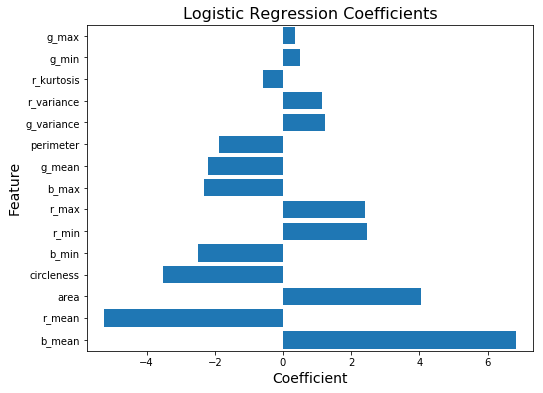

In [129]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(np.arange(len(coefs['abs_coef'].values)), coefs['coef'], 0.8, align='center')

ax.set_yticks(np.arange(len(coefs['abs_coef'].values)))
ax.set_yticklabels(coefs['feature'], fontsize=10)
ax.set_ylabel('Feature', fontsize=14)
ax.set_xlabel('Coefficient', fontsize=14)
ax.set_ylim([-0.5, 14.5])
ax.set_xlim([coefs['coef'].min()-0.5, coefs['coef'].max()+0.5])
ax.set_title('Logistic Regression Coefficients', fontsize=16)
plt.show()

Random Forest

In [135]:

rf = RandomForestClassifier()

rf_params = {
    'max_features':[None,'log2','sqrt', 2,3,4,5],
    'max_depth':[1,2,3,4,5,10,None],
    'min_samples_leaf': [1],
    'n_estimators':[50]
}

rf_gs = GridSearchCV(rf, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_gs.fit(X_train, y_train)
print('Done fitting.')

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  5.3min finished


Done fitting.


In [136]:
rf_best = rf_gs.best_estimator_
print('Random Forest GridsearchCV Results:')
print('Best Estimator', rf_best)
print('Best Parameters',  rf_gs.best_params_)
print('Best Score', '%0.4f' % rf_gs.best_score_, '\n')

# Check results against hold out test set 

print('Cross Validation on Test Set:')
print('Score: ', '%0.4f' % rf_gs.score(X_test, y_test))
print('Baseline Accuracy: ', '%0.4f' % y_base)
print('Percent Better: ', '%0.4f' % ((rf_gs.score(X_test, y_test) - y_base) / (1 - y_base)))

Random Forest GridsearchCV Results:
Best Estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best Parameters {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Best Score 0.9811 

Cross Validation on Test Set:
Score:  0.9823
Baseline Accuracy:  0.9221
Percent Better:  0.7734


In [137]:
feature_importance = pd.DataFrame({'feature': X.columns,
                                   'importance': rf_best.feature_importances_})

feature_importance.sort_values('importance', ascending=False, inplace=True)

feature_importance

,feature,importance
6,r_variance,0.280504
12,g_variance,0.128066
18,b_variance,0.086275
2,circleness,0.065510
1,area,0.057792
0,perimeter,0.035554
7,r_skewness,0.034026
5,r_mean,0.033076
3,r_min,0.026403
17,b_mean,0.024825


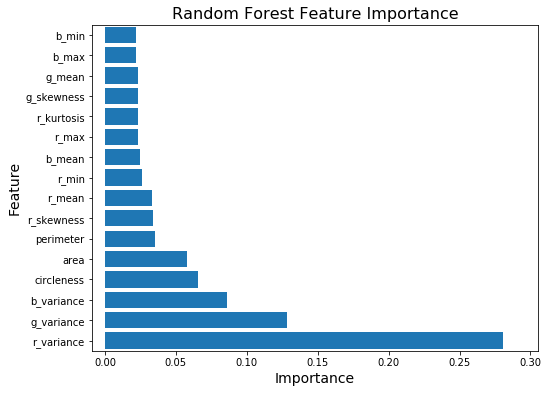

In [138]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(np.arange(len(feature_importance['importance'].values)), feature_importance['importance'], 0.8, align='center')

ax.set_yticks(np.arange(len(feature_importance['importance'].values)))
ax.set_yticklabels(feature_importance['feature'], fontsize=10)
ax.set_ylabel('Feature', fontsize=14)
ax.set_xlabel('Importance', fontsize=14)
ax.set_ylim([-0.5, 15.5])
ax.set_xlim([feature_importance['importance'].min()-0.025, feature_importance['importance'].max()+0.025])
ax.set_title('Random Forest Feature Importance', fontsize=16)
plt.show()

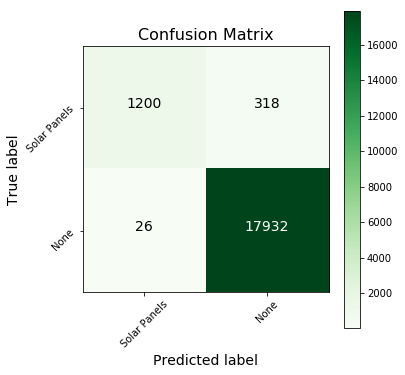

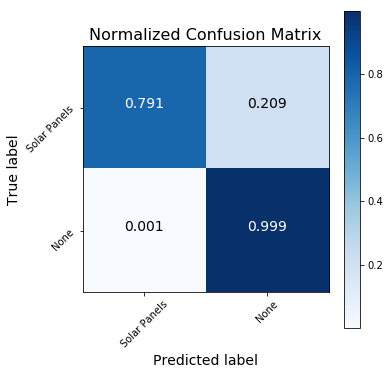

In [139]:
y_pred_lr = lr_gs.predict(X_test)
y_prob_lr = lr_gs.predict_proba(X_test)[:,1]

y_pred_rf = rf_gs.predict(X_test)
y_prob_rf = rf_gs.predict_proba(X_test)[:,1]

plot_confusion_matrix(y_test, y_pred_rf, title='Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_rf, normalize=True, cmap=plt.cm.Blues, title='Normalized Confusion Matrix')

In [110]:
# Use classifier outputs to return dataframe with false positives, false negatives, and associated probabilities

def misclassified(y_true, y_prob, y_pred, error='all'):

    y_prob_series = pd.Series(y_prob, index=y_true.index)
    
    misclassified = pd.DataFrame({'y_true': y_true, 
                                  'y_pred': y_pred,
                                  'y_prob': y_prob_series}, 
                                 columns=['y_true', 'y_pred', 'y_prob'])

    misclassified = misclassified[misclassified['y_true'] != misclassified['y_pred']]
    misclassified['kind'] = misclassified['y_true'].map(lambda x: 'fp' if x == 0 else 'fn')
    misclassified.reset_index(inplace=True)
        
    fn = misclassified[misclassified['kind'] == 'fn'].sort_values(by='y_prob')
    fp = misclassified[misclassified['kind'] == 'fp'].sort_values(by='y_prob', ascending=False)
    
    if error == 'all':
        return misclassified
    elif error == 'fn':
        return fn
    else:
        return fp

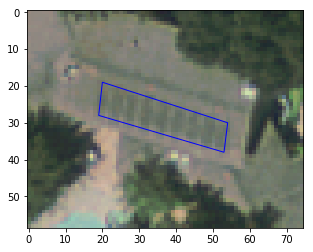

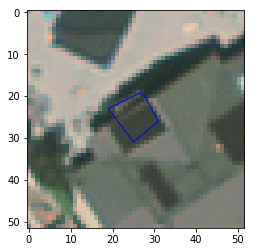

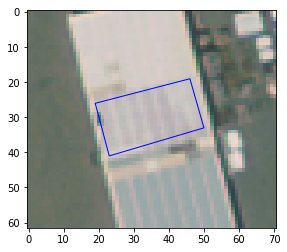

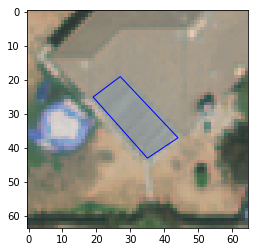

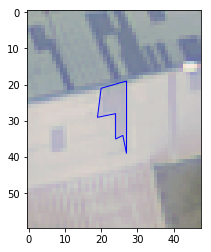

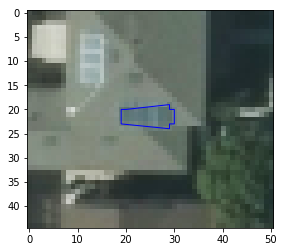

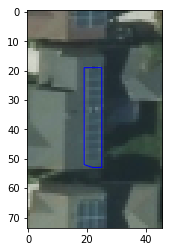

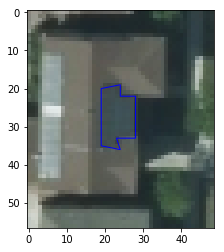

In [113]:
# Plot false negatives with lowest 'panel' probability

fn_ids = misclassified(y_test, y_prob_rf, y_pred_rf, error='fn')['index'].values[:8]
fn_poly_ids = combined_features[combined_features.index.isin(fn_ids)]['segment_id'].values
fn_poly_images = combined_features[combined_features.index.isin(fn_ids)]['image_id'].values

for img, poly in zip(fn_poly_images, fn_poly_ids):
    plot_polygon(poly)
